In [1]:
import numpy as np
from matplotlib import pyplot as plt
import libs.MEVeS as S
import libs.AtomicConstants.Atom as A
import libs.Optimiser as Opt
import plotly.express as px

In [2]:
pi_unicode = "\u03C0"
times_unicode = "\u00D7"

# HOM example computed in time domain

In [6]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 4}, "intermediate": {"n": 6, "J": 3/2}, 
                                                    "storage": {"n": 6, "L":0, "F" : 3}}}
atom = A.Cs(config)

In [28]:
T = 0 # temperature of the ensemble in K
vno = 1 # number of velocity classes to simulate.
L = 0.075 # length of the cell in m

OD = 5000

n = 200 # number of space steps. Note these are not evenly spaced.

protocol = 'Raman'
tau = 1e-9
m = 800
detuning = 2*np.pi*2*atom.deltaHF

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

t0 = 3*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
control_pol = np.array([1, 0]) #should be normalised

## Input photon

Storage efficiency =  47 %


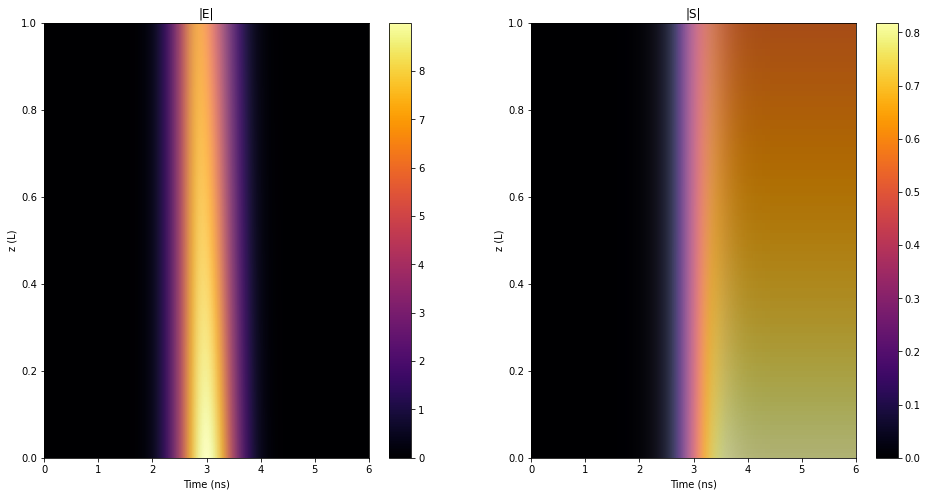

In [29]:
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 
Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

sol1 = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Omega = 2*np.pi*2e9
Control_tp = (S.gaussian(t, t0, tau, Omega))[:, None] * control_pol[None, :] # control field

Control_tzp = sol1.co_prop( Control_tp )
sol1.solve(Control_tzp, method='RK4-Ralston')

storage1 = sol1.storage_efficiency(sol1.S, mi=-1)

print(f"Storage efficiency = {storage1*100: .0f} %")

# 2d plots of coherences

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax[0].pcolormesh(t*1e9, sol1.zCheby, np.abs(sol1.E[:, :, 0]).T, cmap=colour)

fig.colorbar(im, ax=ax[0])

ax[0].pcolormesh(t*1e9, sol1.zCheby, np.abs(Control_tzp(sol1.t_grid, sol1.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)

ax[0].set_xlabel("Time (ns)")
ax[0].set_ylabel("z (L)")
ax[0].set_title("|E|")

im = ax[1].pcolormesh(t*1e9, sol1.zCheby, np.abs(sol1.S[:, :, 0, 0, 0, 0, 0]).T, cmap=colour)

fig.colorbar(im, ax=ax[1])

ax[1].pcolormesh(t*1e9, sol1.zCheby, np.abs(Control_tzp(sol1.t_grid, sol1.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)

ax[1].set_xlabel("Time (ns)")
ax[1].set_ylabel("z (L)")
ax[1].set_title("|S|")

plt.show()

## Input spin wave

In [30]:
Sinits = np.ones((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial flat spin wave

np.trapz(pow(np.abs(Sinits[:, 0, 0, 0, 0, 0]), 2), axis=0, x=sol1.zCheby)

1.0

Retrieval efficiency =  49 %


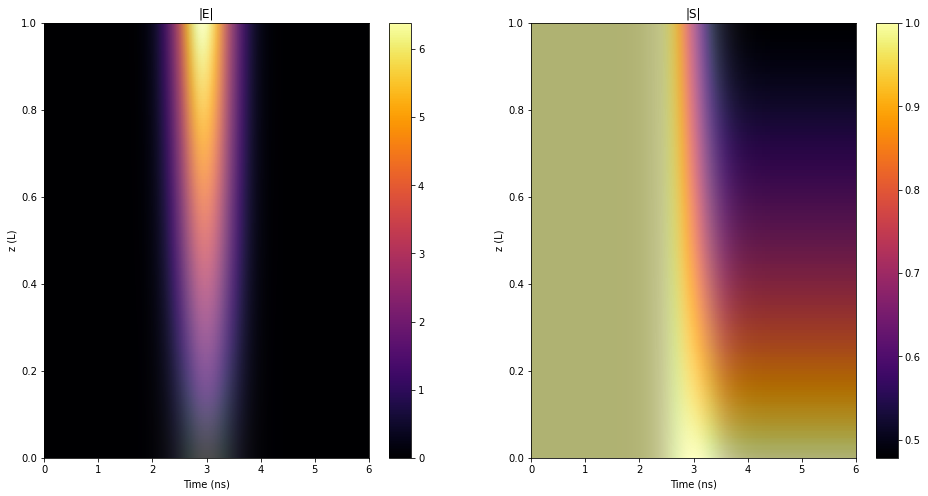

In [31]:
Einits = np.zeros(m)[:, None] * photon_pol[None, :] # no input photons

sol2 = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Omega = 2*np.pi*2e9
Control_tp = (S.gaussian(t, t0, tau, Omega))[:, None] * control_pol[None, :] # control field

Control_tzp = sol2.co_prop( Control_tp )
sol2.solve(Control_tzp, method='RK4-Ralston')

retrieval2 = sol2.retrieval_efficiency(sol2.E, 0, 0)

print(f"Retrieval efficiency = {retrieval2*100: .0f} %")

# 2d plots of coherences

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax[0].pcolormesh(t*1e9, sol2.zCheby, np.abs(sol2.E[:, :, 0]).T, cmap=colour)

fig.colorbar(im, ax=ax[0])

ax[0].pcolormesh(t*1e9, sol2.zCheby, np.abs(Control_tzp(sol2.t_grid, sol2.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)

ax[0].set_xlabel("Time (ns)")
ax[0].set_ylabel("z (L)")
ax[0].set_title("|E|")

im = ax[1].pcolormesh(t*1e9, sol2.zCheby, np.abs(sol2.S[:, :, 0, 0, 0, 0, 0]).T, cmap=colour)

fig.colorbar(im, ax=ax[1])

ax[1].pcolormesh(t*1e9, sol2.zCheby, np.abs(Control_tzp(sol2.t_grid, sol2.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)

ax[1].set_xlabel("Time (ns)")
ax[1].set_ylabel("z (L)")
ax[1].set_title("|S|")

plt.show()

## Compute non interacting classical probabilites (ignore loss)

In [32]:
P11c = (np.trapz(pow(np.abs(sol1.E[:, -1, 0]), 2), x=sol1.tpoints)*np.trapz(pow(np.abs(sol2.S[-1, :, 0, 0, 0, 0, 0]), 2), x=sol2.zCheby) 
        + np.trapz(pow(np.abs(sol2.E[:, -1, 0]), 2), x=sol2.tpoints)*np.trapz(pow(np.abs(sol1.S[-1, :, 0, 0, 0, 0, 0]), 2), x=sol1.zCheby)) 
P20c = (np.trapz(pow(np.abs(sol1.E[:, -1, 0]), 2), x=sol1.tpoints)*np.trapz(pow(np.abs(sol2.E[:, -1, 0]), 2), x=sol2.tpoints))
P02c = (np.trapz(pow(np.abs(sol1.S[-1, :, 0, 0, 0, 0, 0]), 2), x=sol1.zCheby)*np.trapz(pow(np.abs(sol2.S[-1, :, 0, 0, 0, 0, 0]), 2), x=sol2.zCheby))

Pallc = P11c+P02c+P20c

print(f"P11c = {P11c: .2f}")
print(f"P20c = {P20c: .2f}")
print(f"P02c = {P02c: .2f}")
print(f"Pallc = {Pallc: .2f}")

P11c =  0.50
P20c =  0.26
P02c =  0.24
Pallc =  1.00


## Compute interacting quantum probabilities

In [33]:
# need to normalise S correctly for overlap calculation
S1norm = np.trapz(np.abs(sol1.S[:, :, 0, 0, 0, 0, 0])**2, x=sol1.tpoints, axis=0)
S1norm[S1norm==0] = 1
S1bar = sol1.S[:, :, 0, 0, 0, 0, 0]/np.sqrt(S1norm) * np.abs(sol1.S[-1, :, 0, 0, 0, 0, 0])

S2norm = np.trapz(np.abs(sol2.S[:, :, 0, 0, 0, 0, 0])**2, x=sol2.tpoints, axis=0)
S2norm[S2norm==0] = 1
S2bar = sol2.S[:, :, 0, 0, 0, 0, 0]/np.sqrt(S2norm) * np.abs(sol2.S[-1, :, 0, 0, 0, 0, 0])

In [34]:
# quantum probability

P11q = (P11c + 
        2*np.real( np.trapz(np.trapz(np.conj(S2bar)*S1bar, x=sol1.tpoints, axis=0), x=sol1.zCheby, axis=0)
                  *np.trapz(np.conj(sol1.E[:, -1, 0])*sol2.E[:, -1, 0], x=sol1.tpoints, axis=0) )
)

P20q = (P20c + 
        np.real( np.trapz(np.conj(sol1.E[:, -1, 0])*sol2.E[:, -1, 0], x=sol1.tpoints, axis=0)*
                  np.trapz(np.conj(sol2.E[:, -1, 0])*sol1.E[:, -1, 0], x=sol1.tpoints, axis=0) )
)

P02q = (P02c + 
        np.trapz(np.real( np.trapz(np.conj(S1bar)*S2bar, x=sol1.tpoints, axis=0)
                  *np.trapz(np.conj(S2bar)*S1bar, x=sol1.tpoints, axis=0) ), x=sol1.zCheby, axis=0)
)

print(f"P11q = {P11q: .2f}")
print(f"P20q = {P20q: .2f}")
print(f"P02q = {P02q: .2f}")

Pallq = P11q+P02q+P20q
print(f"Pallq = {Pallq: .2f}")

P11q =  0.23
P20q =  0.48
P02q =  0.35
Pallq =  1.05


# Scan Omega

## Input photon

In [58]:
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 
Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

num_Omega = 50
Omega_list = np.linspace(0.1, 4, num_Omega)

Eouts1 = np.zeros((num_Omega, m), dtype=complex)
Souts1 = np.zeros((num_Omega, m, n), dtype=complex)

for i in range(0, num_Omega):

    sol1 = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

    Omega = 2*np.pi*1e9 * Omega_list[i]
    Control_tp = (S.gaussian(t, t0, tau, Omega))[:, None] * control_pol[None, :] # control field

    Control_tzp = sol1.co_prop( Control_tp )
    sol1.solve(Control_tzp, method='RK4-Ralston')

    Eouts1[i] = sol1.E[:, -1, 0]
    Souts1[i] = sol1.S[:, :, 0, 0, 0, 0, 0]


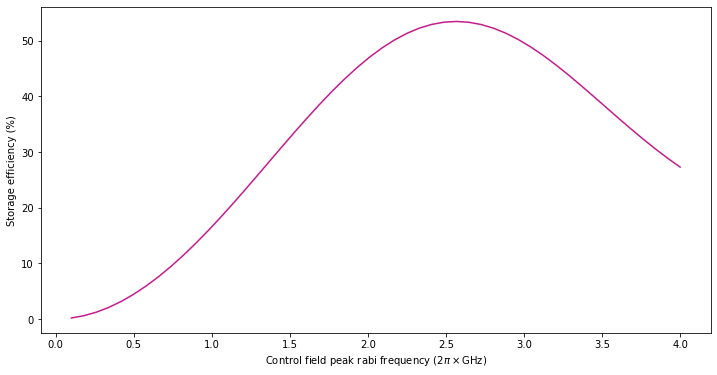

In [59]:
storage_eff = []
for Sout1 in Souts1:
    storage_eff.append( sol1.storage_efficiency(Sout1[:, :, None, None, None, None, None], -1) )

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Omega_list, np.array(storage_eff)*100, color='#c51b8aff')
ax.set_ylabel('Storage efficiency (%)', color='k')
ax.set_xlabel(r'Control field peak rabi frequency ($2\pi \times$GHz)')
plt.show()

## Input spin wave

In [60]:
Sinits = np.ones((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial flat spin wave

np.trapz(pow(np.abs(Sinits[:, 0, 0, 0, 0, 0]), 2), axis=0, x=sol1.zCheby)

1.0

In [61]:
Einits = np.zeros(m)[:, None] * photon_pol[None, :] # no input photons

Eouts2= np.zeros((num_Omega, m), dtype=complex)
Souts2 = np.zeros((num_Omega, m, n), dtype=complex)

for i in range(0, num_Omega):

    sol2 = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

    Omega = 2*np.pi*1e9 * Omega_list[i]
    Control_tp = (S.gaussian(t, t0, tau, Omega))[:, None] * control_pol[None, :] # control field

    Control_tzp = sol2.co_prop( Control_tp )
    sol2.solve(Control_tzp, method='RK4-Ralston')

    Eouts2[i] = sol2.E[:, -1, 0]
    Souts2[i] = sol2.S[:, :, 0, 0, 0, 0, 0]

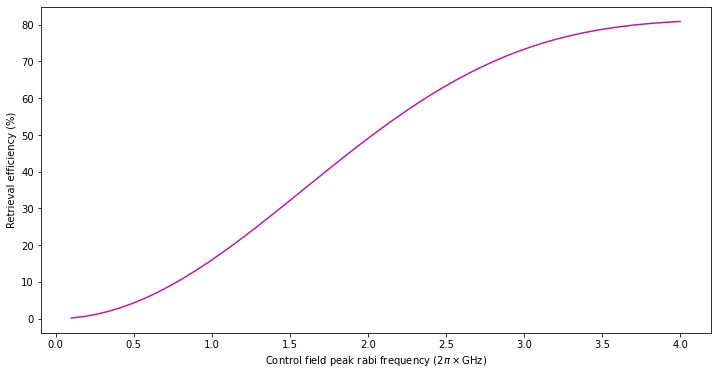

In [62]:
retrieval_eff = []
for Eout2 in Eouts2:
    retrieval_eff.append( sol2.retrieval_efficiency(Eout2[:, None, None], 0, 0) )

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Omega_list, np.array(retrieval_eff)*100, color='#c51b8aff')
ax.set_ylabel('Retrieval efficiency (%)', color='k')
ax.set_xlabel(r'Control field peak rabi frequency ($2\pi \times$GHz)')
plt.show()

## Compute non interacting classical probabilites (ignore loss)

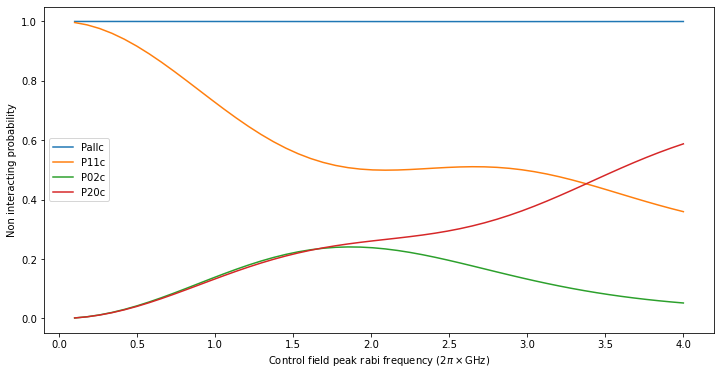

In [63]:
P11c = (np.trapz(pow(np.abs(Eouts1), 2), axis=1, x=sol1.tpoints)*np.trapz(pow(np.abs(Souts2[:, -1]), 2), axis=1, x=sol2.zCheby) 
        + np.trapz(pow(np.abs(Eouts2), 2), axis=1, x=sol2.tpoints)*np.trapz(pow(np.abs(Souts1[:, -1]), 2), axis=1, x=sol1.zCheby)) 
P20c = (np.trapz(pow(np.abs(Eouts1), 2), axis=1, x=sol1.tpoints)*np.trapz(pow(np.abs(Eouts2), 2), axis=1, x=sol2.tpoints))
P02c = (np.trapz(pow(np.abs(Souts1[:, -1]), 2), axis=1, x=sol1.zCheby)*np.trapz(pow(np.abs(Souts2[:, -1]), 2), axis=1, x=sol2.zCheby))

Pallc = P11c+P02c+P20c

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Omega_list, Pallc, label='Pallc')
ax.plot(Omega_list, P11c, label='P11c')
ax.plot(Omega_list, P02c, label='P02c')
ax.plot(Omega_list, P20c, label='P20c')
ax.set_ylabel('Non interacting probability', color='k')
ax.set_xlabel(r'Control field peak rabi frequency ($2\pi \times$GHz)')
plt.legend()
plt.show()

## Compute interacting quantum probabilities

In [64]:
# need to normalise S correctly for overlap calculation
S1norm = np.trapz(np.abs(Souts1)**2, x=sol1.tpoints, axis=1)
S1norm[S1norm==0] = 1
S1bar = Souts1/np.sqrt(S1norm[:, None, :]) * np.abs(Souts1[:, -1])[:, None, :]

S2norm = np.trapz(np.abs(Souts2)**2, x=sol2.tpoints, axis=1)
S2norm[S2norm==0] = 1
S2bar = Souts2/np.sqrt(S2norm[:, None, :]) * np.abs(Souts2[:, -1])[:, None, :]

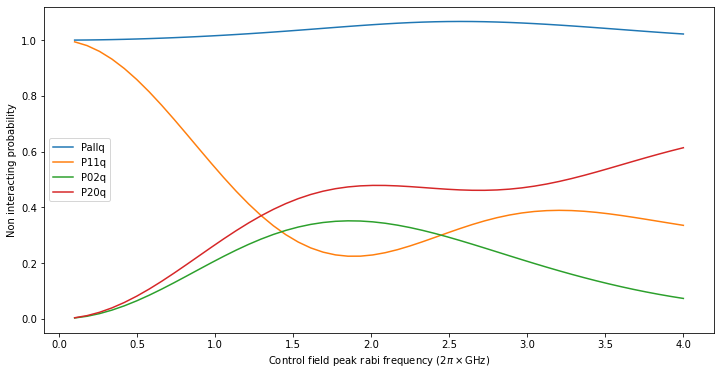

In [65]:
# quantum probability

P11q = (P11c + 
        2*np.real( np.trapz(np.trapz(np.conj(S2bar)*S1bar, x=sol1.tpoints, axis=1), x=sol1.zCheby, axis=1)
                  *np.trapz(np.conj(Eouts1)*Eouts2, x=sol1.tpoints, axis=1) )
)

P20q = (P20c + 
        np.real( np.trapz(np.conj(Eouts1)*Eouts2, x=sol1.tpoints, axis=1)*
                  np.trapz(np.conj(Eouts2)*Eouts1, x=sol1.tpoints, axis=1) )
)

P02q = (P02c + 
        np.trapz(np.real( np.trapz(np.conj(S1bar)*S2bar, x=sol1.tpoints, axis=1)
                  *np.trapz(np.conj(S2bar)*S1bar, x=sol1.tpoints, axis=1) ), x=sol1.zCheby, axis=1)
)


Pallq = P11q+P02q+P20q

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Omega_list, Pallq, label='Pallq')
ax.plot(Omega_list, P11q, label='P11q')
ax.plot(Omega_list, P02q, label='P02q')
ax.plot(Omega_list, P20q, label='P20q')
ax.set_ylabel('Non interacting probability', color='k')
ax.set_xlabel(r'Control field peak rabi frequency ($2\pi \times$GHz)')
plt.legend()
plt.show()

# Non perfect storage

In [3]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 4}, "intermediate": {"n": 6, "J": 3/2}, 
                                                    "storage": {"n": 6, "L":0, "F" : 3}}}
atom = A.Cs(config)

In [4]:
T = 0 # temperature of the ensemble in K
vno = 1 # number of velocity classes to simulate.
L = 0.075 # length of the cell in m

OD = 5000

n = 50 # number of space steps. Note these are not evenly spaced.

protocol = 'Raman'
tau = 1e-9
m = 200
detuning = 2*np.pi*2*atom.deltaHF

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

t0 = 3*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
control_pol = np.array([1, 0]) #should be normalised

In [10]:
num_Omega = 20
Omega_list = np.linspace(0.1, 4, num_Omega)

Eouts0 = np.zeros((num_Omega, num_Omega, m), dtype=complex)
Souts0 = np.zeros((num_Omega, num_Omega, m, n), dtype=complex)
Eouts1 = np.zeros((num_Omega, num_Omega, m), dtype=complex)
Souts1 = np.zeros((num_Omega, num_Omega, m, n), dtype=complex)
Eouts2 = np.zeros((num_Omega, num_Omega, m), dtype=complex)
Souts2 = np.zeros((num_Omega, num_Omega, m, n), dtype=complex)

for i in range(0, num_Omega):
    for j in range(0, num_Omega):
        # initial storage
        Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 
        Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

        sol0 = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

        Omega = 2*np.pi*1e9 * Omega_list[i]
        Control_tp = (S.gaussian(t, t0, tau, Omega))[:, None] * control_pol[None, :] # control field

        Control_tzp = sol0.co_prop( Control_tp )
        sol0.solve(Control_tzp, method='RK4-Ralston')

        Eouts0[i, j] = sol0.E[:, -1, 0]
        Souts0[i, j] = sol0.S[:, :, 0, 0, 0, 0, 0]
        
        # second input photon
        Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 
        Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

        sol1 = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

        Omega = 2*np.pi*1e9 * Omega_list[j]
        Control_tp = (S.gaussian(t, t0, tau, Omega))[:, None] * control_pol[None, :] # control field

        Control_tzp = sol1.co_prop( Control_tp )
        sol1.solve(Control_tzp, method='RK4-Ralston')

        Eouts1[i, j] = sol1.E[:, -1, 0]
        Souts1[i, j] = sol1.S[:, :, 0, 0, 0, 0, 0]

        # input stored coherence
        Einits = np.zeros(m)[:, None] * photon_pol[None, :] 
        Sinits = sol0.S[-1]

        sol2 = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

        Omega = 2*np.pi*1e9 * Omega_list[j]
        Control_tp = (S.gaussian(t, t0, tau, Omega))[:, None] * control_pol[None, :] # control field

        Control_tzp = sol2.co_prop( Control_tp )
        sol2.solve(Control_tzp, method='RK4-Ralston')

        Eouts2[i, j] = sol2.E[:, -1, 0]
        Souts2[i, j] = sol2.S[:, :, 0, 0, 0, 0, 0]

In [11]:
P11c = (np.trapz(pow(np.abs(Eouts1), 2), axis=2, x=sol1.tpoints)*np.trapz(pow(np.abs(Souts2[:, :, -1]), 2), axis=2, x=sol2.zCheby) 
        + np.trapz(pow(np.abs(Eouts2), 2), axis=2, x=sol2.tpoints)*np.trapz(pow(np.abs(Souts1[:, :, -1]), 2), axis=2, x=sol1.zCheby)) 
P20c = (np.trapz(pow(np.abs(Eouts1), 2), axis=2, x=sol1.tpoints)*np.trapz(pow(np.abs(Eouts2), 2), axis=2, x=sol2.tpoints))
P02c = (np.trapz(pow(np.abs(Souts1[:, :, -1]), 2), axis=2, x=sol1.zCheby)*np.trapz(pow(np.abs(Souts2[:, :, -1]), 2), axis=2, x=sol2.zCheby))

Pallc = P11c+P02c+P20c

In [17]:
fig = px.imshow(P11c.T, text_auto = '.2f', x = Omega_list, y = Omega_list, color_continuous_scale='Viridis',
                labels=dict(x=f'C1 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', 
                            y=f'C2 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', color="P11c"), origin='lower')
fig.update_layout(width = 800,height = 800, font=dict(size=16))
fig.show(renderer = 'vscode')

fig = px.imshow(P20c.T, text_auto = '.2f', x = Omega_list, y = Omega_list, color_continuous_scale='Viridis',
                labels=dict(x=f'C1 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', 
                            y=f'C2 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', color="P20c"), origin='lower')
fig.update_layout(width = 800,height = 800, font=dict(size=16))
fig.show(renderer = 'vscode')

fig = px.imshow(P02c.T, text_auto = '.2f', x = Omega_list, y = Omega_list, color_continuous_scale='Viridis',
                labels=dict(x=f'C1 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', 
                            y=f'C2 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', color="P02c"), origin='lower')
fig.update_layout(width = 800,height = 800, font=dict(size=16))
fig.show(renderer = 'vscode')

fig = px.imshow(Pallc.T, text_auto = '.2f', x = Omega_list, y = Omega_list, color_continuous_scale='Viridis',
                labels=dict(x=f'C1 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', 
                            y=f'C2 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', color="Pallc"), origin='lower')
fig.update_layout(width = 800,height = 800, font=dict(size=16))
fig.show(renderer = 'vscode')

In [13]:
# need to normalise S correctly for overlap calculation
S1norm = np.trapz(np.abs(Souts1)**2, x=sol1.tpoints, axis=2)
S1norm[S1norm==0] = 1
S1bar = Souts1/np.sqrt(S1norm[:, :, None, :]) * np.abs(Souts1[:, :, -1])[:, :, None, :]

S2norm = np.trapz(np.abs(Souts2)**2, x=sol2.tpoints, axis=2)
S2norm[S2norm==0] = 1
S2bar = Souts2/np.sqrt(S2norm[:, :, None, :]) * np.abs(Souts2[:, :, -1])[:, :, None, :]

In [26]:
# quantum probability

P11q = (P11c + 
        2*np.real( np.trapz(np.trapz(np.conj(S2bar)*S1bar, x=sol1.tpoints, axis=2), x=sol1.zCheby, axis=2)
                  *np.trapz(np.conj(Eouts1)*Eouts2, x=sol1.tpoints, axis=2) )
)

P20q = (P20c + 
        np.real( np.trapz(np.conj(Eouts1)*Eouts2, x=sol1.tpoints, axis=2)*
                  np.trapz(np.conj(Eouts2)*Eouts1, x=sol1.tpoints, axis=2) )
)

P02q = (P02c + 
        np.trapz(np.real( np.trapz(np.conj(S1bar)*S2bar, x=sol1.tpoints, axis=2)
                  *np.trapz(np.conj(S2bar)*S1bar, x=sol1.tpoints, axis=2) ), x=sol1.zCheby, axis=2)
)


Pallq = P11q+P02q+P20q

In [27]:
fig = px.imshow(P11q.T, text_auto = '.2f', x = Omega_list, y = Omega_list, color_continuous_scale='Viridis',
                labels=dict(x=f'C1 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', 
                            y=f'C2 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', color="P11q"), origin='lower')
fig.update_layout(width = 800,height = 800, font=dict(size=16))
fig.show(renderer = 'vscode')

fig = px.imshow(P20q.T, text_auto = '.2f', x = Omega_list, y = Omega_list, color_continuous_scale='Viridis',
                labels=dict(x=f'C1 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', 
                            y=f'C2 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', color="P20q"), origin='lower')
fig.update_layout(width = 800,height = 800, font=dict(size=16))
fig.show(renderer = 'vscode')

fig = px.imshow(P02q.T, text_auto = '.2f', x = Omega_list, y = Omega_list, color_continuous_scale='Viridis',
                labels=dict(x=f'C1 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', 
                            y=f'C2 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', color="P02q"), origin='lower')
fig.update_layout(width = 800,height = 800, font=dict(size=16))
fig.show(renderer = 'vscode')

fig = px.imshow(Pallq.T, text_auto = '.2f', x = Omega_list, y = Omega_list, color_continuous_scale='Viridis',
                labels=dict(x=f'C1 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', 
                            y=f'C2 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', color="Pallq"), origin='lower')
fig.update_layout(width = 800,height = 800, font=dict(size=16))
fig.show(renderer = 'vscode')

### Difference between classical and quantum

In [28]:
fig = px.imshow(P11q.T - P11c.T, text_auto = '.2f', x = Omega_list, y = Omega_list, color_continuous_scale='Viridis',
                labels=dict(x=f'C1 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', 
                            y=f'C2 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', color="P11"), origin='lower')
fig.update_layout(width = 800,height = 800, font=dict(size=16))
fig.show(renderer = 'vscode')

fig = px.imshow(P20q.T - P20c.T, text_auto = '.2f', x = Omega_list, y = Omega_list, color_continuous_scale='Viridis',
                labels=dict(x=f'C1 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', 
                            y=f'C2 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', color="P20"), origin='lower')
fig.update_layout(width = 800,height = 800, font=dict(size=16))
fig.show(renderer = 'vscode')

fig = px.imshow(P02q.T - P02c.T, text_auto = '.2f', x = Omega_list, y = Omega_list, color_continuous_scale='Viridis',
                labels=dict(x=f'C1 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', 
                            y=f'C2 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', color="P02"), origin='lower')
fig.update_layout(width = 800,height = 800, font=dict(size=16))
fig.show(renderer = 'vscode')

fig = px.imshow(Pallq.T - Pallc.T, text_auto = '.2f', x = Omega_list, y = Omega_list, color_continuous_scale='Viridis',
                labels=dict(x=f'C1 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', 
                            y=f'C2 peak rabi frequency (2{pi_unicode} {times_unicode}GHz)', color="Pall"), origin='lower')
fig.update_layout(width = 800,height = 800, font=dict(size=16))
fig.show(renderer = 'vscode')